# Survival Analysis and COX Proportional Hazards

`Author: José Luis Maldonado Álvarez`

In [1]:
suppressWarnings(
    suppressPackageStartupMessages({
        library(knitr)
        library(dplyr)
        library(survival) # main package for survival analysis
        library(survminer) # for customizable graphs of survival function
        library(broom) # for tidy output 
        library(ggplot2)
        library(tibble) # for tibble data frames from survival objects
        library(readxl)
        library(lubridate) # for date manipulation
        library(ggsurvfit) # for ggplot2 style survival plots
        library(caret) # for dummy variables
        library(forcats) # for factor manipulation (reordering, etc.)
        library(ggthemes) # for additional themes and scales for plots
        library(ggrepel) # for better text labels in plots
    })
)

In [2]:
df <- read.csv('FINAL_DATASET_CLUSTERED.csv')
# Convert all columns to numeric except for MH_AGE, SE_HI (factors) and the ones that end with "date" (converted to Date)
df <- suppressWarnings(df %>%
    mutate(across(c(MH_AGE, SE_HI), as.factor)) %>%
    mutate(across(-c(ID,MH_AGE, SE_HI, ends_with("date")), as.numeric)) %>%
    mutate(across(ends_with("date"), ymd)))
    # mutate(across(ends_with("date"), as.Date, format = "%Y-%m-%d"))

# head(df)
# dim(df)
# str(df) # Check the formats have been converted correctly

In [3]:
# CREATE dummy variables for categorical variables MH_AGE, SE_HI and cluster_kmodes with dummyVars (caret)
# Needed for cox regression

dummies <- dummyVars(~ MH_AGE + SE_HI, data = df)
df_dummies <- as.data.frame(predict(dummies, newdata = df))
df <- bind_cols(df, df_dummies)

dummies <- dummyVars(~ as.factor(cluster_kmodes), data = df)
df_dummies <- as.data.frame(predict(dummies, newdata = df))
df <- bind_cols(df, df_dummies)

str(df)

'data.frame':	2109 obs. of  55 variables:
 $ ID                        : int  1 2 3 4 5 6 10 12 13 17 ...
 $ MH_AGE                    : Factor w/ 3 levels "(60,71]","(71,93]",..: 3 2 3 1 1 2 2 3 1 1 ...
 $ MH_SEX                    : num  1 1 1 0 1 1 0 1 1 0 ...
 $ MH_OB                     : num  1 1 0 0 1 0 0 0 0 1 ...
 $ MH_FHID                   : num  0 0 0 1 0 1 1 1 0 0 ...
 $ MH_SMK                    : num  1 3 1 3 2 1 3 1 2 1 ...
 $ MH_DM                     : num  0 0 0 0 1 0 0 0 0 1 ...
 $ MH_HT                     : num  1 1 0 0 1 1 1 0 0 1 ...
 $ MH_DLP                    : num  1 0 0 1 1 1 0 1 1 0 ...
 $ MH_CKD                    : num  0 0 0 0 0 0 0 0 NA 0 ...
 $ MH_PMI                    : num  1 0 0 0 0 1 0 1 1 0 ...
 $ MH_PCS                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_PPCI                   : num  0 0 0 0 1 1 0 1 1 0 ...
 $ MH_PAD                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_STK                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_HMG      

In [4]:
# Read the Excel file with the Admission Dates data
data_ext <- read_excel("Base_Extendida_Incompleta.xlsx", sheet = "Datos")

# Create a new data frame with the columns Id as ID and `Fecha entrada`
fentrada <- data_ext %>%
  select(Id, `Fecha entrada`) %>%
  rename(ID = Id, Fecha_entrada = `Fecha entrada`) %>%
  mutate(Fecha_entrada = ymd(Fecha_entrada)) 

# Merge the two data frames on the ID column
df <- merge(df, fentrada, by = "ID", all.x = TRUE)
dim(df)
head(df)
# summary(df$Fecha_entrada)

[1] 2109   56

,ID,MH_AGE,MH_SEX,MH_OB,MH_FHID,MH_SMK,MH_DM,MH_HT,MH_DLP,MH_CKD,⋯,"MH_AGE.(60,71]","MH_AGE.(71,93]","MH_AGE.[28,60]","SE_HI.(30707,34138.7]","SE_HI.(34138.7, 76251]","SE_HI.[25649,30707]",as.factor(cluster_kmodes)1,as.factor(cluster_kmodes)2,as.factor(cluster_kmodes)3,Fecha_entrada
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
1,1,"[28,60]",1,1,0,1,0,1,1,0,⋯,0,0,1,1,0,0,1,0,0,2018-02-21
2,2,"(71,93]",1,1,0,3,0,1,0,0,⋯,0,1,0,0,1,0,0,0,1,2018-02-22
3,3,"[28,60]",1,0,0,1,0,0,0,0,⋯,0,0,1,1,0,0,0,1,0,2018-02-23
4,4,"(60,71]",0,0,1,3,0,0,1,0,⋯,1,0,0,1,0,0,1,0,0,2018-02-23
5,5,"(60,71]",1,1,0,2,1,1,1,0,⋯,1,0,0,0,1,0,0,0,1,2018-02-22
6,6,"(71,93]",1,0,1,1,0,1,1,0,⋯,0,1,0,0,1,0,0,1,0,2018-02-25


In [5]:
# Add a new column for the time to event in days
df <- df %>%
    # mutate(time_to_event = as.duration(Fecha_entrada %--% OUT_MACEdate) / dyears(1))
    mutate(time_to_event = as.numeric(difftime(OUT_MACEdate, Fecha_entrada, units = "days")))

summary(df$time_to_event)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1642    2292    2019    2693    3211 

In [6]:
df %>% 
    filter(df$time_to_event %in% c(3206, 3207, 3211)) %>% 
    select(ID, time_to_event, OUT_MACE)

ID,time_to_event,OUT_MACE
<int>,<dbl>,<dbl>
909,3211,0
912,3206,1
972,3207,0


In [7]:
# Rename columns for clarity
df <- df %>%
    rename(
        time = time_to_event,
        MACE = OUT_MACE,
        age60_71 = "MH_AGE.(60,71]" ,
        age71_93 = "MH_AGE.(71,93]",
        age28_60 = "MH_AGE.[28,60]",
        HI_med = "SE_HI.(30707,34138.7]",
        HI_high = "SE_HI.(34138.7, 76251]",
        HI_low = "SE_HI.[25649,30707]",
        C1 = "as.factor(cluster_kmodes)1",
        C2 = "as.factor(cluster_kmodes)2",
        C3 = "as.factor(cluster_kmodes)3"
    )
# str(df)

## Kaplan-Meier estimation with $\texttt{survfit()}$

List of 17
 $ n        : int 2109
 $ time     : num [1:1357] 0 1 2 3 4 5 6 7 8 9 ...
 $ n.risk   : num [1:1357] 2109 2089 2076 2071 2064 ...
 $ n.event  : num [1:1357] 3 5 1 1 1 1 0 0 2 1 ...
 $ n.censor : num [1:1357] 17 8 4 6 6 8 5 4 2 0 ...
 $ surv     : num [1:1357] 0.999 0.996 0.996 0.995 0.995 ...
 $ std.err  : num [1:1357] 0.000822 0.001351 0.001434 0.001513 0.001589 ...
 $ cumhaz   : num [1:1357] 0.00142 0.00382 0.0043 0.00478 0.00527 ...
 $ std.chaz : num [1:1357] 0.000821 0.001349 0.001433 0.001512 0.001588 ...
 $ type     : chr "right"
 $ logse    : logi TRUE
 $ conf.int : num 0.95
 $ conf.type: chr "log"
 $ lower    : num [1:1357] 0.997 0.994 0.993 0.992 0.992 ...
 $ upper    : num [1:1357] 1 0.999 0.999 0.998 0.998 ...
 $ t0       : num 0
 $ call     : language survfit(formula = Surv(time, MACE) ~ 1, data = df)
 - attr(*, "class")= chr "survfit"
Call: survfit(formula = Surv(time, MACE) ~ 1, data = df)

        n events median 0.95LCL 0.95UCL
[1,] 2109    405   3206    3206

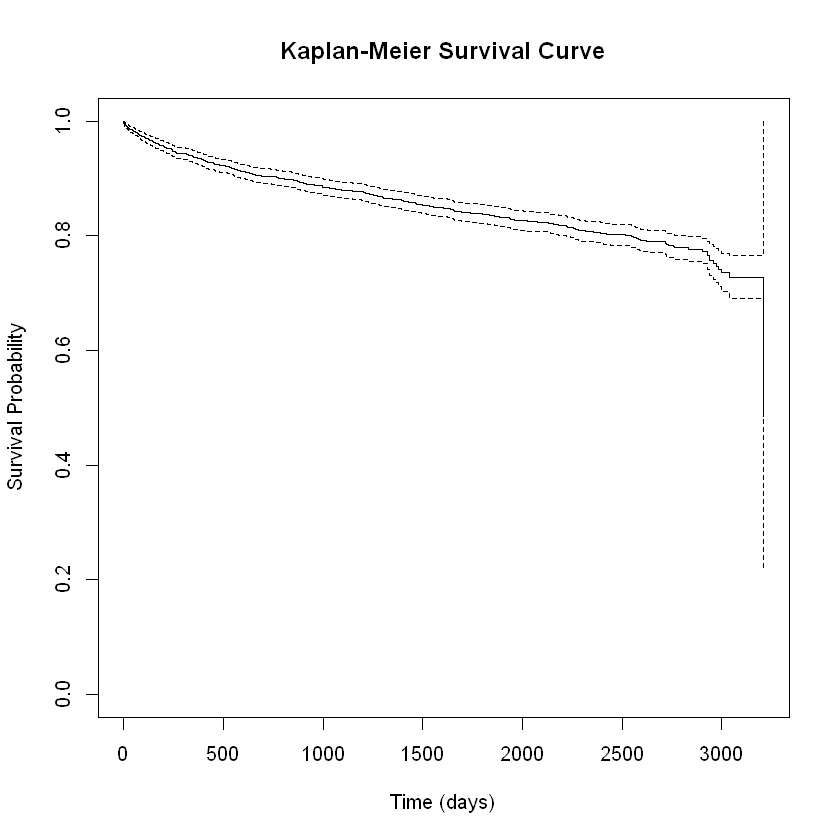

In [8]:
KM <- survfit(Surv(time, MACE) ~ 1, data = df)
str(KM)
print(KM) # Median survival is the time at which survival probability is 0.5
par(bg = "white")
plot(KM, ylab = "Survival Probability", xlab = "Time (days)", main = "Kaplan-Meier Survival Curve")

`Call`: Shows the function and arguments used to create the KM object. It is useful to know how the result was generated.

`n`: total number at risk (Number of individuals at the start of the analysis).

`event`: Number of observed events (for example, how many had the OUT_MACE event, in this case 405).

`median`: survival time $t$ at which $S(t) = 0.5$, or the time at which 50% of those at risk are expected to still be alive

`0.95LCL`, `0.95UCL`: 95% confidence limits for median survival

NOTE: Ignoring censoring leads to *overestimate* overall survival probability and *underestimate* median survival time. ⬇️

In [9]:
df %>% 
  filter(MACE == 1) %>% 
  summarize(median_surv = median(time)) # median understimated by ignoring censored data

median_surv
<dbl>
793


In [10]:
KM_tidy <- tidy(KM)
KM_tidy

time,n.risk,n.event,n.censor,estimate,std.error,conf.high,conf.low
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2109,3,17,0.9985775,0.0008218511,1.0000000,0.9969703
1,2089,5,8,0.9961874,0.0013505357,0.9988278,0.9935540
2,2076,1,4,0.9957076,0.0014339070,0.9985099,0.9929132
3,2071,1,6,0.9952268,0.0015130612,0.9981826,0.9922798
4,2064,1,6,0.9947446,0.0015887745,0.9978470,0.9916519
5,2057,1,8,0.9942610,0.0016615223,0.9975041,0.9910285
6,2048,0,5,0.9942610,0.0016615223,0.9975041,0.9910285
7,2043,0,4,0.9942610,0.0016615223,0.9975041,0.9910285
8,2039,2,2,0.9932858,0.0018006067,0.9967974,0.9897865


Using `tidy()` function from the `broom` package on the `survfit()` object produces a table of the KM estimate of the survival function $S(t)$

- `time`  event/censoring times in the data set
- `n.risk`, `n.event`, `n.censor`  number at risk, number of events, number censored
- `estimate`  $\hat{S}(t)$ survival estimate  
  - $\hat{S}(0) = \left(1 - \frac{3}{2109}\right) = 0.9985775$
  - $\hat{S}(1) = \left(1 - \frac{3}{2109}\right)\left(1 - \frac{5}{2089}\right) = 0.9961874$
- `std.error`, `conf.high`, `conf.low`  standard error for $\hat{S}(t)$, and 95% confidence

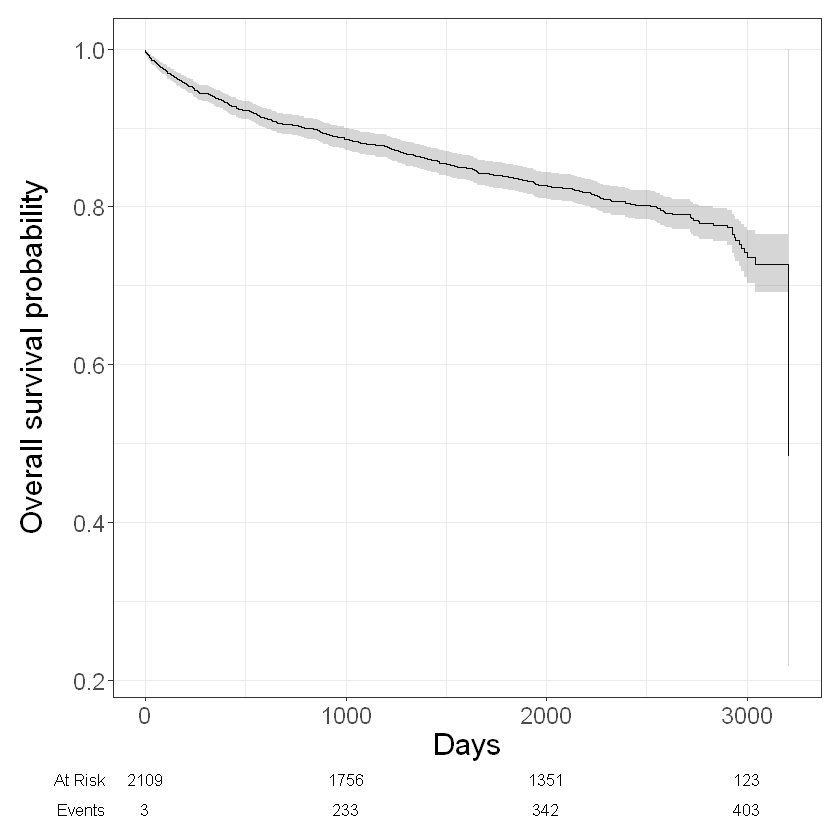

In [11]:
survfit2(Surv(time, MACE) ~ 1, data = df) %>%
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable() +
  theme(
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

In [12]:
# Estimating x-year survival
summary(survfit(Surv(time, MACE) ~ 1, data = df), times = 365)


Call: survfit(formula = Surv(time, MACE) ~ 1, data = df)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
  365   1894     130    0.936 0.00541        0.926        0.947

## Comparing Survival Curves: Stratified Kaplan-Meier estimates

Call: survfit(formula = Surv(time, MACE) ~ SE_STU, data = df)

            n events median 0.95LCL 0.95UCL
SE_STU=1 1209    261   3206      NA      NA
SE_STU=2  900    144     NA      NA      NA

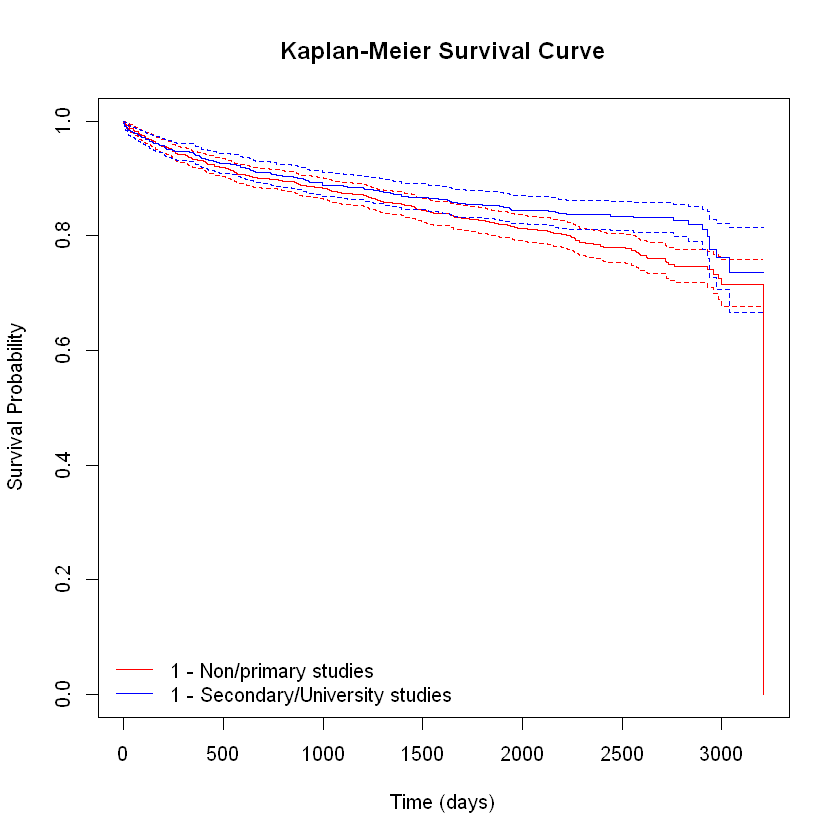

In [13]:
survfit(Surv(time, MACE) ~ SE_STU, data = df) # Compares median, n and events for each level
# tidy(survfit(Surv(time, MACE) ~ SE_STU, data = df))
par(bg = "white")
plot(survfit(Surv(time, MACE) ~ SE_STU, data = df), 
     main = "Kaplan-Meier Survival Curve",
     ylab = "Survival Probability", 
     xlab = "Time (days)", 
     conf.int = TRUE, 
     col = c("red", "blue"))
legend("bottomleft", legend = c("1 - Non/primary studies", "1 - Secondary/University studies"),
       col = c("red", "blue"), lty = 1, bty = "n")

We can test the hypothesis:

$$
\begin{align*}
H_0\!: & \quad \text{survival curves across 2 or more groups are equivalent} \\
H_A\!: & \quad \text{survival curves across 2 or more groups are not equivalent}
\end{align*}
$$

The log-rank statistic is one popular method to evaluate this hypothesis. Under the null, the log-rank statistic is $\chi^2$ distributed with $g - 1$ degrees of freedom. The function `survdiff()` performs the log-rank test by default with $\rho$ = 0.⬇️

In [14]:
# Comparing survival times between groups
survdiff(Surv(time, MACE) ~ SE_MS, data = df)
# We see theres no significant difference in survival between the two groups (p-value = 0.1)

survdiff(Surv(time, MACE) ~ SE_INT, data = df)
# We see significant difference in survival between the two groups (p-value = 3e-08)

survdiff(Surv(time, MACE) ~ SE_STU, data = df)
# We see significant difference in survival between the two groups (p-value = 0.008)

survdiff(Surv(time, MACE) ~ OUT_STK, data = df) # OBVIOUS significant difference

survdiff(Surv(time, MACE) ~ SE_HI, data = df)
survdiff(Surv(time, MACE) ~ SE_EX, data = df)
survdiff(Surv(time, MACE) ~ SE_PET, data = df)

Call:
survdiff(formula = Surv(time, MACE) ~ SE_MS, data = df)

           N Observed Expected (O-E)^2/E (O-E)^2/V
SE_MS=1 1489      273      287     0.718      2.48
SE_MS=2  620      132      118     1.754      2.48

 Chisq= 2.5  on 1 degrees of freedom, p= 0.1 

Call:
survdiff(formula = Surv(time, MACE) ~ SE_INT, data = df)

            N Observed Expected (O-E)^2/E (O-E)^2/V
SE_INT=0  480      137     90.7     23.63      30.5
SE_INT=1 1629      268    314.3      6.82      30.5

 Chisq= 30.5  on 1 degrees of freedom, p= 3e-08 

Call:
survdiff(formula = Surv(time, MACE) ~ SE_STU, data = df)

            N Observed Expected (O-E)^2/E (O-E)^2/V
SE_STU=1 1209      261      235      2.95      7.02
SE_STU=2  900      144      170      4.06      7.02

 Chisq= 7  on 1 degrees of freedom, p= 0.008 

Call:
survdiff(formula = Surv(time, MACE) ~ OUT_STK, data = df)

             N Observed Expected (O-E)^2/E (O-E)^2/V
OUT_STK=0 2027      323   396.03      13.5       613
OUT_STK=1   82       82     8.97     594.2       613

 Chisq= 613  on 1 degrees of freedom, p= <2e-16 

Call:
survdiff(formula = Surv(time, MACE) ~ SE_HI, data = df)

                         N Observed Expected (O-E)^2/E (O-E)^2/V
SE_HI=(30707,34138.7]  978      198    192.4    0.1659     0.317
SE_HI=(34138.7, 76251] 986      184    185.4    0.0108     0.020
SE_HI=[25649,30707]    145       23     27.2    0.6581     0.706

 Chisq= 0.8  on 2 degrees of freedom, p= 0.7 

Call:
survdiff(formula = Surv(time, MACE) ~ SE_EX, data = df)

           N Observed Expected (O-E)^2/E (O-E)^2/V
SE_EX=0  749      140      142    0.0396    0.0611
SE_EX=1 1360      265      263    0.0215    0.0611

 Chisq= 0.1  on 1 degrees of freedom, p= 0.8 

Call:
survdiff(formula = Surv(time, MACE) ~ SE_PET, data = df)

            N Observed Expected (O-E)^2/E (O-E)^2/V
SE_PET=0 1319      274      247      2.89      7.43
SE_PET=1  790      131      158      4.53      7.43

 Chisq= 7.4  on 1 degrees of freedom, p= 0.006 

**Weighted log-rank tests:**  
`survdiff()` allows weights in calculation of the $\chi^2$ statistic with the `rho=` argument. The weights are defined as $\hat{S}(t)^\rho$, where $0 \leq \rho \leq 1$.

- `rho=0` equal weights, $\hat{S}(t)^0 = 1$, which is the log-rank test and the default  
- `rho=1` the weights equal the survival estimate itself, $\hat{S}(t)^1 = \hat{S}(t)$, equivalent to the Gehan-Wilcoxon test  
    - earlier timepoints are weighted more heavily (might make sense for death after surgery, for example)
- `rho=` values between 0 and 1 are valid, with values closer to 1 putting more weight on earlier time points

In [15]:
survdiff(Surv(time, MACE) ~ SE_MS, data = df, rho=1)

Call:
survdiff(formula = Surv(time, MACE) ~ SE_MS, data = df, rho = 1)

           N Observed Expected (O-E)^2/E (O-E)^2/V
SE_MS=1 1489      245      258     0.625      2.38
SE_MS=2  620      118      106     1.524      2.38

 Chisq= 2.4  on 1 degrees of freedom, p= 0.1 

In [16]:
survdiff(Surv(time, MACE) ~ MH_AGE, data = df)
survdiff(Surv(time, MACE) ~ cluster_kmodes, data = df)
survdiff(Surv(time, MACE) ~ cluster_pam, data = df) # clusterization non-significant!!

Call:
survdiff(formula = Surv(time, MACE) ~ MH_AGE, data = df)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
MH_AGE=(60,71] 701      110      138      5.52      8.37
MH_AGE=(71,93] 666      187      123     33.01     47.48
MH_AGE=[28,60] 742      108      144      9.10     14.16

 Chisq= 47.7  on 2 degrees of freedom, p= 4e-11 

Call:
survdiff(formula = Surv(time, MACE) ~ cluster_kmodes, data = df)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
cluster_kmodes=1 831      156    162.0     0.225     0.375
cluster_kmodes=2 815      124    155.4     6.363    10.343
cluster_kmodes=3 463      125     87.5    16.053    20.499

 Chisq= 22.7  on 2 degrees of freedom, p= 1e-05 

Call:
survdiff(formula = Surv(time, MACE) ~ cluster_pam, data = df)

                N Observed Expected (O-E)^2/E (O-E)^2/V
cluster_pam=1 424       71     82.5      1.59      2.01
cluster_pam=2 510      111     97.6      1.85      2.44
cluster_pam=3 699      150    137.1      1.21      1.83
cluster_pam=4 476       73     87.8      2.51      3.21

 Chisq= 7.2  on 3 degrees of freedom, p= 0.07 

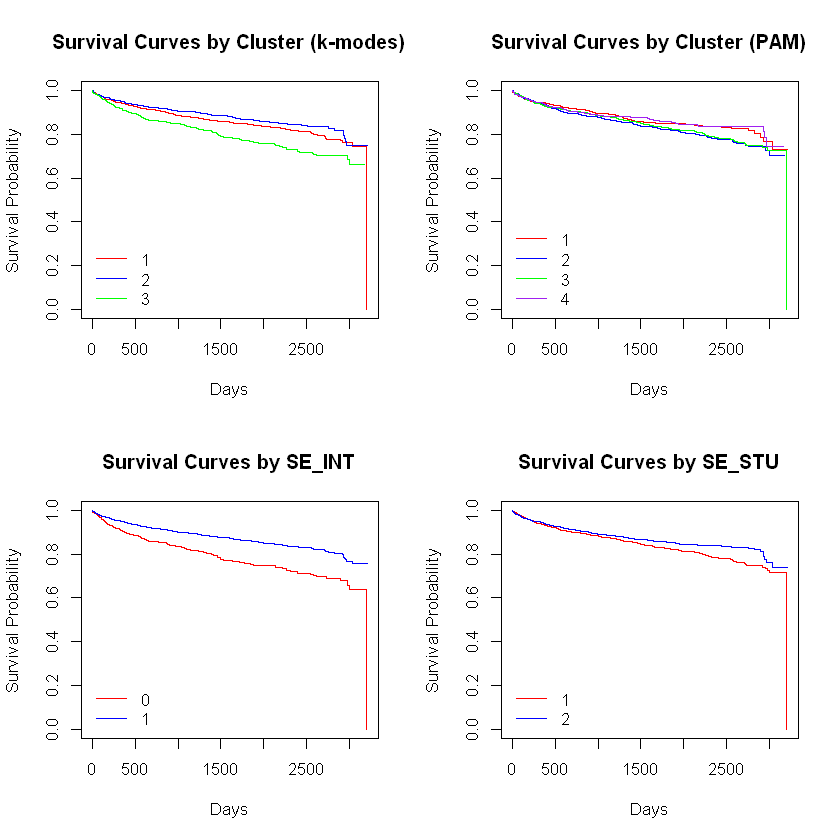

In [17]:
par(mfrow = c(2, 2),bg = "white") # Set up a 2x2 plotting area
plot(survfit(Surv(time, MACE) ~ cluster_kmodes, data = df), 
    col = c("red", "blue", "green"),
    xlab = "Days",
    ylab = "Survival Probability",
    main = "Survival Curves by Cluster (k-modes)")
legend("bottomleft", legend = levels(as.factor(df$cluster_kmodes)), 
      col = c("red", "blue", "green"), lty = 1, bty = "n")
plot(survfit(Surv(time, MACE) ~ cluster_pam, data = df), 
    col = c("red", "blue", "green", "purple"),
    xlab = "Days",
    ylab = "Survival Probability",
    main = "Survival Curves by Cluster (PAM)")
legend("bottomleft", legend = levels(as.factor(df$cluster_pam)), 
      col = c("red", "blue", "green", "purple"), lty = 1, bty = "n")
plot(survfit(Surv(time, MACE) ~ SE_INT, data = df), 
    col = c("red", "blue", "green"),
    xlab = "Days",
    ylab = "Survival Probability",
    main = "Survival Curves by SE_INT")
legend("bottomleft", legend = levels(as.factor(df$SE_INT)), 
      col = c("red", "blue", "green"), lty = 1, bty = "n")
plot(survfit(Surv(time, MACE) ~ SE_STU, data = df), 
    col = c("red", "blue", "green"),
    xlab = "Days",
    ylab = "Survival Probability",
    main = "Survival Curves by SE_STU")
legend("bottomleft", legend = levels(as.factor(df$SE_STU)), 
      col = c("red", "blue", "green"), lty = 1, bty = "n")

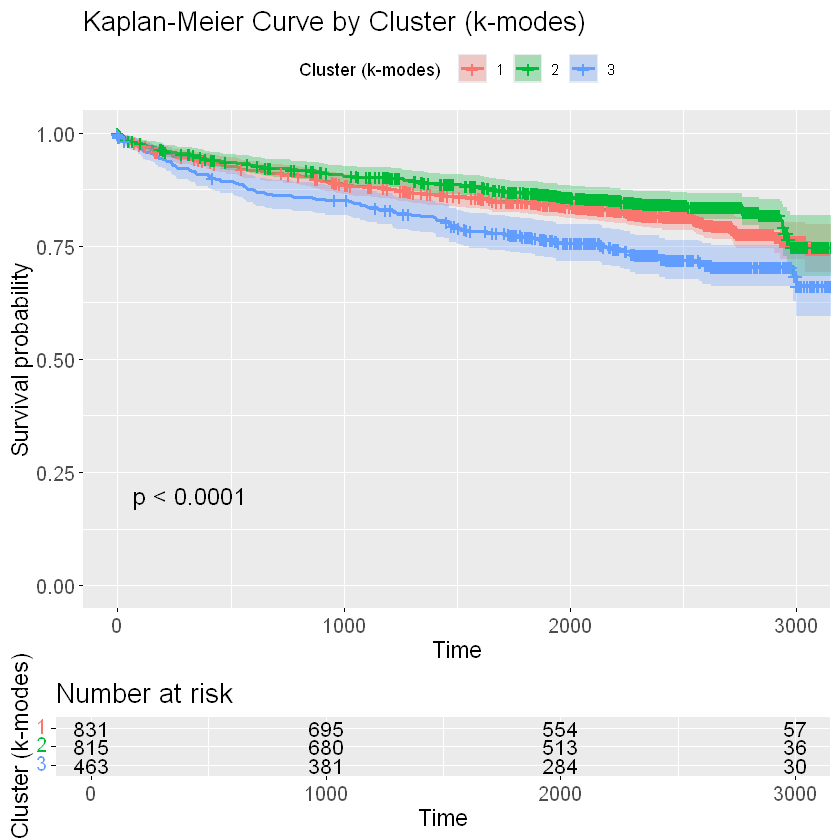

In [18]:
ggsurvplot(
    survfit(Surv(time, MACE) ~ cluster_kmodes, data = df),
    conf.int = TRUE,
    pval = TRUE,
    risk.table = TRUE,
    legend.labs = levels(as.factor(df$cluster_kmodes)),
    legend.title = "Cluster (k-modes)",
    title = "Kaplan-Meier Curve by Cluster (k-modes)",
    risk.table.height = .2,
    ggtheme = theme(
        plot.title = element_text(size = 16),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
    )
)

Call:
survdiff(formula = Surv(time, MACE) ~ C1 + C2 + C3, data = df)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
C1=0, C2=0, C3=1 463      125     87.5    16.053    20.499
C1=0, C2=1, C3=0 815      124    155.4     6.363    10.343
C1=1, C2=0, C3=0 831      156    162.0     0.225     0.375

 Chisq= 22.7  on 2 degrees of freedom, p= 1e-05 

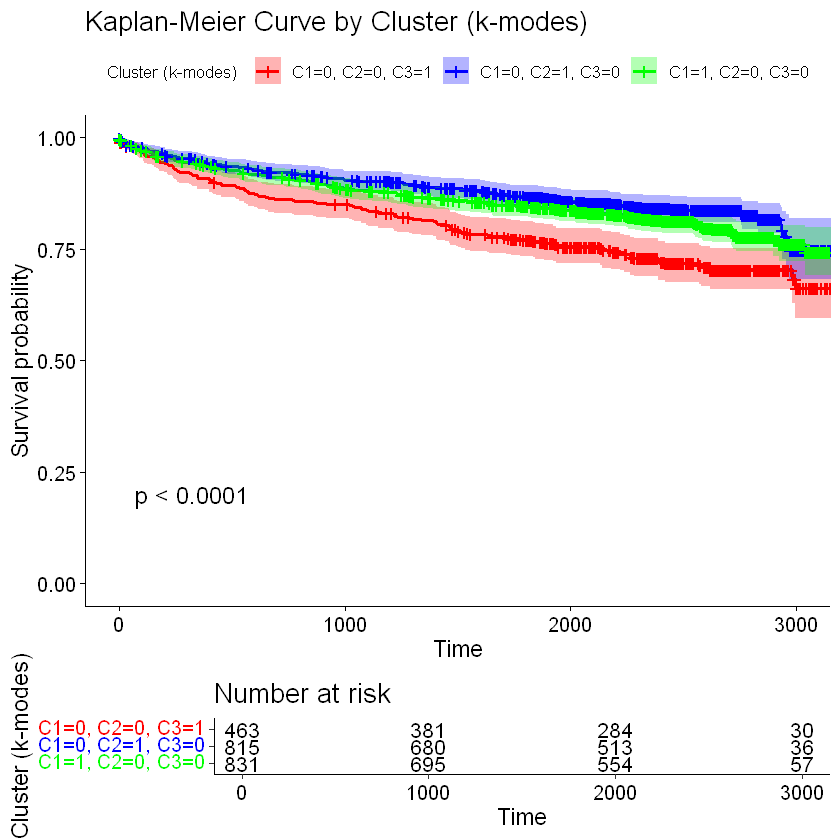

In [19]:
ggsurvplot(
    survfit(Surv(time, MACE) ~ C1 + C2 + C3, data = df),
    conf.int = TRUE,
    pval = TRUE,
    risk.table = TRUE,
    legend.labs = levels(c(3,2,1)),
    legend.title = "Cluster (k-modes)",
    palette = c("red", "blue", "green"),
    title = "Kaplan-Meier Curve by Cluster (k-modes)",
    risk.table.height = .2
)
survdiff(Surv(time, MACE) ~ C1 + C2 + C3, data = df)

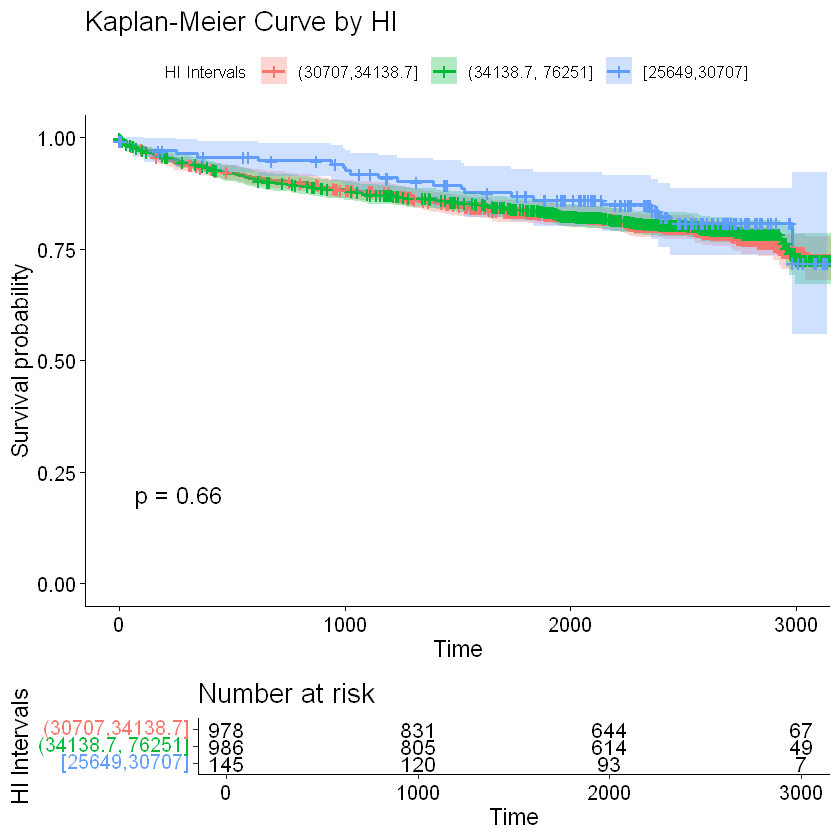

In [20]:
ggsurvplot(
    survfit(Surv(time, MACE) ~ SE_HI, data = df),
    conf.int = TRUE,
    pval = TRUE,
    risk.table = TRUE,
    legend.labs = levels(as.factor(df$SE_HI)),
    legend.title = "HI Intervals",
    title = "Kaplan-Meier Curve by HI",
    risk.table.height = .2) # changing ggtheme

## COX Proportional Hazards Model

Instead of estimating the survival function $S(t)$ directly, the Cox proportional hazards model estimates changes to the hazard function, $h(t)$.

The Cox model can estimate the effects of multiple predictors on the hazard function.

By far the most popular method for survival analysis:

- no distribution assumed for survival times
- naturally accommodates right-censoring and time-varying covariates
- can be extended in many ways:
    - time-varying coefficients
    - random effect frailties for recurrent events or clustering
    - competing risks modeling

**Fitting a Cox model**

Using `coxph(formula, data=)`. The *formula* resembles a typical R regression formula: `Surv(time, event) ~ x1 + x2…` where *x1 + x2…* is a list of one or more predictor variables separated by `+`.

In [21]:
summary(coxph(Surv(time, MACE) ~ SE_MS + SE_SUP + SE_STU, data = df))

Call:
coxph(formula = Surv(time, MACE) ~ SE_MS + SE_SUP + SE_STU, data = df)

  n= 2109, number of events= 405 

          coef exp(coef) se(coef)      z Pr(>|z|)   
SE_MS   0.1238    1.1318   0.1095  1.130  0.25835   
SE_SUP -0.4125    0.6620   0.2635 -1.565  0.11750   
SE_STU -0.2766    0.7583   0.1040 -2.660  0.00781 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
SE_MS     1.1318     0.8836    0.9131    1.4028
SE_SUP    0.6620     1.5106    0.3949    1.1096
SE_STU    0.7583     1.3187    0.6185    0.9298

Concordance= 0.54  (se = 0.014 )
Likelihood ratio test= 11.55  on 3 df,   p=0.009
Wald test            = 11.8  on 3 df,   p=0.008
Score (logrank) test = 11.91  on 3 df,   p=0.008


- Sample size: 2109, number of events: 405  
- `coef`: log hazard ratio coefficients  
    - Positive coefficients (e.g., SE_MS = 0.1240) indicate increased log-hazard and lower survival; negative coefficients (e.g., SE_SUP = -0.4126, SE_STU = -0.2768) indicate decreased log-hazard and higher survival.
- `exp(coef)`: hazard ratios (exponentiated coefficients)  
    - $\hat{HR}_{SE\_MS} = 1.13$: Belonging to SE_MS group is associated with a 13% increase in hazard (not statistically significant, p = 0.26).
    - $\hat{HR}_{SE\_SUP} = 0.66$: Belonging to SE_SUP group is associated with a 34% decrease in hazard (not statistically significant, p = 0.12).
    - $\hat{HR}_{SE\_STU} = 0.76$: Belonging to SE_STU group is associated with a 24% decrease in hazard (statistically significant, p = 0.008).
- `se(coef)`: standard error of log hazard ratios
- `Pr(>|z|)`: p-value for test of log hazard ratio = 0, or equivalently, hazard ratio = 1  
    - Only SE_STU is statistically significant at the 0.05 level.
- `lower .95`, `upper .95`: 95% confidence interval for hazard ratio  
    - For SE_STU, the 95% CI (0.62, 0.93) does not include 1, supporting a significant effect.
    - For SE_MS and SE_SUP, the CIs include 1, indicating no clear effect.
- `Concordance`: 0.54 (se = 0.014), a measure of model predictive accuracy.
- `Likelihood ratio`, `Wald`, and `Score` tests: All indicate the model as a whole is statistically significant (p ≈ 0.008–0.009).

In [22]:
# Cox Proportional Hazards Model
coxph(Surv(time, MACE) ~ age28_60, data = df)
coxph(Surv(time, MACE) ~ age60_71, data = df)
coxph(Surv(time, MACE) ~ age71_93, data = df)

Call:
coxph(formula = Surv(time, MACE) ~ age28_60, data = df)

            coef exp(coef) se(coef)      z        p
age28_60 -0.4200    0.6570   0.1124 -3.736 0.000187

Likelihood ratio test=14.82  on 1 df, p=0.0001185
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ age60_71, data = df)

            coef exp(coef) se(coef)     z       p
age60_71 -0.3220    0.7247   0.1118 -2.88 0.00397

Likelihood ratio test=8.69  on 1 df, p=0.003207
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ age71_93, data = df)

            coef exp(coef) se(coef)     z        p
age71_93 0.67426   1.96259  0.09971 6.762 1.36e-11

Likelihood ratio test=44.15  on 1 df, p=3.036e-11
n= 2109, number of events= 405 

In [23]:
coxph(Surv(time, MACE) ~ HI_low, data = df)
coxph(Surv(time, MACE) ~ HI_med, data = df)
coxph(Surv(time, MACE) ~ HI_high, data = df)

Call:
coxph(formula = Surv(time, MACE) ~ HI_low, data = df)

          coef exp(coef) se(coef)      z     p
HI_low -0.1801    0.8352   0.2147 -0.839 0.402

Likelihood ratio test=0.74  on 1 df, p=0.3889
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ HI_med, data = df)

          coef exp(coef) se(coef)     z     p
HI_med 0.05603   1.05763  0.09955 0.563 0.574

Likelihood ratio test=0.32  on 1 df, p=0.5736
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ HI_high, data = df)

            coef exp(coef) se(coef)      z     p
HI_high -0.01412   0.98597  0.09992 -0.141 0.888

Likelihood ratio test=0.02  on 1 df, p=0.8876
n= 2109, number of events= 405 

In [24]:
coxph(Surv(time, MACE) ~ C1, data = df)
coxph(Surv(time, MACE) ~ C2, data = df)
coxph(Surv(time, MACE) ~ C3, data = df)

Call:
coxph(formula = Surv(time, MACE) ~ C1, data = df)

       coef exp(coef) se(coef)      z    p
C1 -0.06251   0.93940  0.10213 -0.612 0.54

Likelihood ratio test=0.38  on 1 df, p=0.5395
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ C2, data = df)

      coef exp(coef) se(coef)    z       p
C2 -0.3453    0.7080   0.1079 -3.2 0.00137

Likelihood ratio test=10.67  on 1 df, p=0.001091
n= 2109, number of events= 405 

Call:
coxph(formula = Surv(time, MACE) ~ C3, data = df)

     coef exp(coef) se(coef)     z        p
C3 0.4827    1.6204   0.1076 4.484 7.32e-06

Likelihood ratio test=18.79  on 1 df, p=1.461e-05
n= 2109, number of events= 405 

- The `exp(coef)` column contains  $e^{\beta_1}$ . This is the **hazard ratio** – the multiplicative effect of that variable on the hazard rate (for each unit increase in that variable).
- For a categorical variable like `C3`, belong to this cluster results in approximately ~48% growth in hazard.
- We could also flip the sign on the `coef` column, and take `exp(0.4829)`, which can be interpreted as:
    - Belonging to cluster C3 is associated with a 1.62-fold increase in hazard, or  
    - Individuals in cluster C3 experience events at approximately 1.62× the rate per unit time compared to those not in cluster C3 (or, conversely, those not in C3 have about 0.62× the hazard of those in C3).
- To be remembered:
    - \( HR = 1 \): No effect
    - \( HR > 1 \): Increase in hazard
    - \( HR < 1 \): Decrease in hazard
- There is a p-value on the `C3` term, and a p-value on the overall model.
    - That **1.447e-05** p-value is really close to the \( p = 1e-05 \) p-value we saw on the Kaplan-Meier plot.
    - That is because the KM plot is showing the log-rank test p-value.
    - We can get this out of the Cox model with a call to `summary(fit)`.
    - You can directly calculate the log-rank test p-value using `survdiff()`.

In [25]:
summary(coxph(Surv(time, MACE) ~ C3, data = df))

Call:
coxph(formula = Surv(time, MACE) ~ C3, data = df)

  n= 2109, number of events= 405 

     coef exp(coef) se(coef)     z Pr(>|z|)    
C3 0.4827    1.6204   0.1076 4.484 7.32e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

   exp(coef) exp(-coef) lower .95 upper .95
C3      1.62     0.6171     1.312     2.001

Concordance= 0.549  (se = 0.012 )
Likelihood ratio test= 18.79  on 1 df,   p=1e-05
Wald test            = 20.11  on 1 df,   p=7e-06
Score (logrank) test = 20.5  on 1 df,   p=6e-06


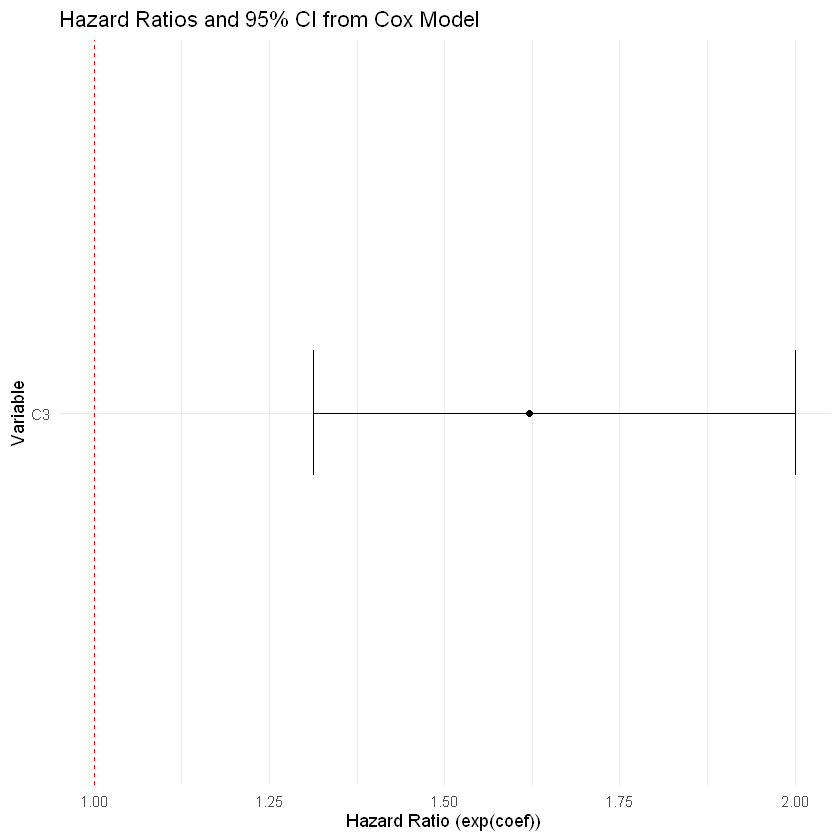

In [26]:
# Extract tidy summary with exponentiated coefficients and confidence intervals
cox_tidy <- tidy(coxph(Surv(time, MACE) ~ C3, data = df), exponentiate = TRUE, conf.int = TRUE) %>% filter(!is.na(estimate))

# Plot hazard ratios with confidence intervals, keeping original variable order
ggplot(cox_tidy, aes(x = term, y = estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
    geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
    coord_flip() +
    labs(
        x = "Variable",
        y = "Hazard Ratio (exp(coef))",
        title = "Hazard Ratios and 95% CI from Cox Model"
    ) +
    theme_minimal()

In [27]:
# Cox Proportional Hazards Model with SE variables
cox_model <- coxph(Surv(time, MACE) ~ SE_MS + SE_SUP + SE_RES + SE_STU + SE_EX + SE_HW + SE_PET + SE_INT + SE_TSI + SE_ACTT + SE_SH + SE_TEH + SE_CCH + SE_ENH + HI_high + HI_low + HI_med, data = df)

In [28]:
# tidy(cox_model)
summary(cox_model)

Call:
coxph(formula = Surv(time, MACE) ~ SE_MS + SE_SUP + SE_RES + 
    SE_STU + SE_EX + SE_HW + SE_PET + SE_INT + SE_TSI + SE_ACTT + 
    SE_SH + SE_TEH + SE_CCH + SE_ENH + HI_high + HI_low + HI_med, 
    data = df)

  n= 2109, number of events= 405 

             coef exp(coef)  se(coef)      z Pr(>|z|)    
SE_MS    0.151876  1.164015  0.116114  1.308  0.19088    
SE_SUP  -0.404408  0.667372  0.275190 -1.470  0.14168    
SE_RES  -0.062013  0.939871  0.106479 -0.582  0.56030    
SE_STU  -0.163355  0.849290  0.112215 -1.456  0.14547    
SE_EX    0.046588  1.047690  0.110226  0.423  0.67255    
SE_HW   -0.342519  0.709980  0.109797 -3.120  0.00181 ** 
SE_PET  -0.245328  0.782448  0.109978 -2.231  0.02570 *  
SE_INT  -0.507726  0.601863  0.114726 -4.426 9.62e-06 ***
SE_TSI   0.002046  1.002048  0.126580  0.016  0.98711    
SE_ACTT -0.121063  0.885978  0.114570 -1.057  0.29066    
SE_SH   -0.371630  0.689609  0.314017 -1.183  0.23662    
SE_TEH   0.145306  1.156394  0.277545  0.524  0.600

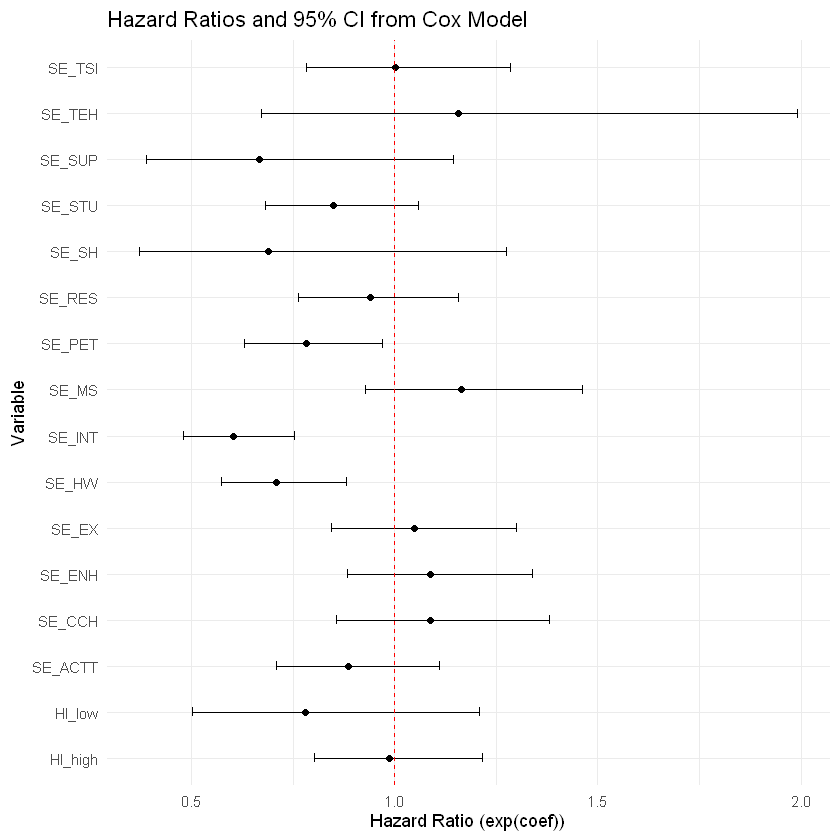

In [29]:
# Extract tidy summary with exponentiated coefficients and confidence intervals
cox_tidy <- tidy(cox_model, exponentiate = TRUE, conf.int = TRUE) %>% filter(!is.na(estimate))

# Plot hazard ratios with confidence intervals, keeping original variable order
ggplot(cox_tidy, aes(x = term, y = estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
    geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
    coord_flip() +
    labs(
        x = "Variable",
        y = "Hazard Ratio (exp(coef))",
        title = "Hazard Ratios and 95% CI from Cox Model"
    ) +
    theme_minimal()

### Assessing porportional hazards assumption

One assumption of the Cox proportional hazards regression model is that the hazards are proportional at each point in time throughout follow-up.

- A hypothesis test of whether the effect of each covariate differs according to time, and a global test of all covariates at once.
    - This is done by testing for an interaction effect between the covariate and log(time)
    - A significant p-value indicates that the proportional hazards assumption is violated
- Plots of the Schoenfeld residuals
- Deviation from a zero-slope line is evidence that the proportional hazards assumption is violated

The function `cox.zph()` provides a convenient solution to test the proportional hazards assumption for each covariate included in a Cox regression model fit.

- For each covariate, the function `cox.zph()` correlates the corresponding set of scaled Schoenfeld residuals with time, to test for independence between residuals and time.
- Additionally, it performs a global test for the model as a whole.
- The proportional hazard assumption is supported by a non-significant relationship between residuals and time, and refuted by a significant relationship.

        chisq df    p
C1     0.0264  1 0.87
C2     0.0045  1 0.95
GLOBAL 0.0269  2 0.99


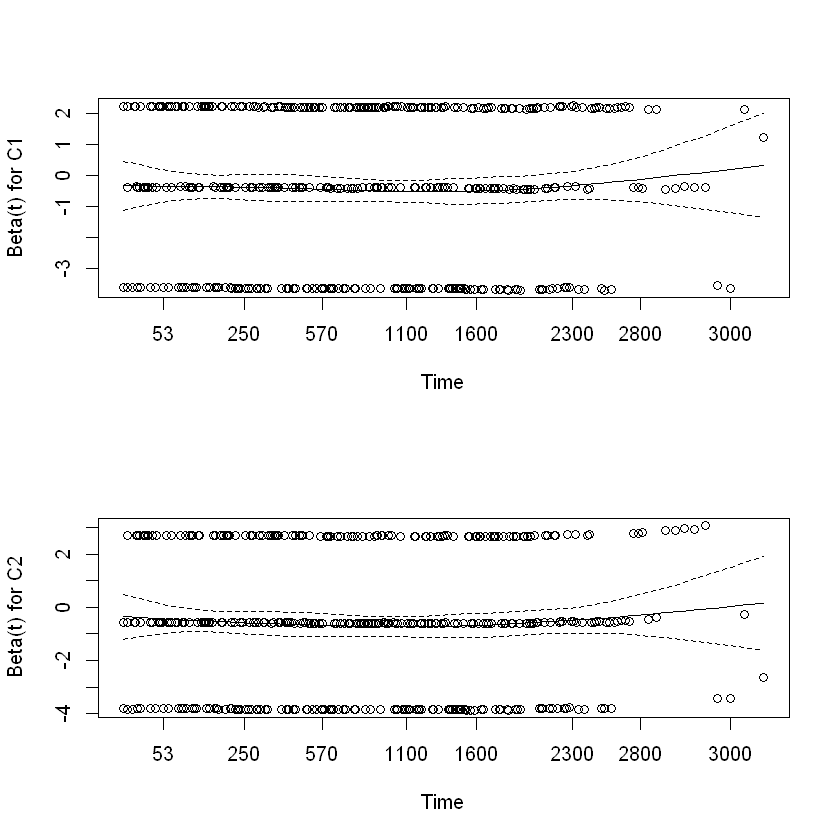

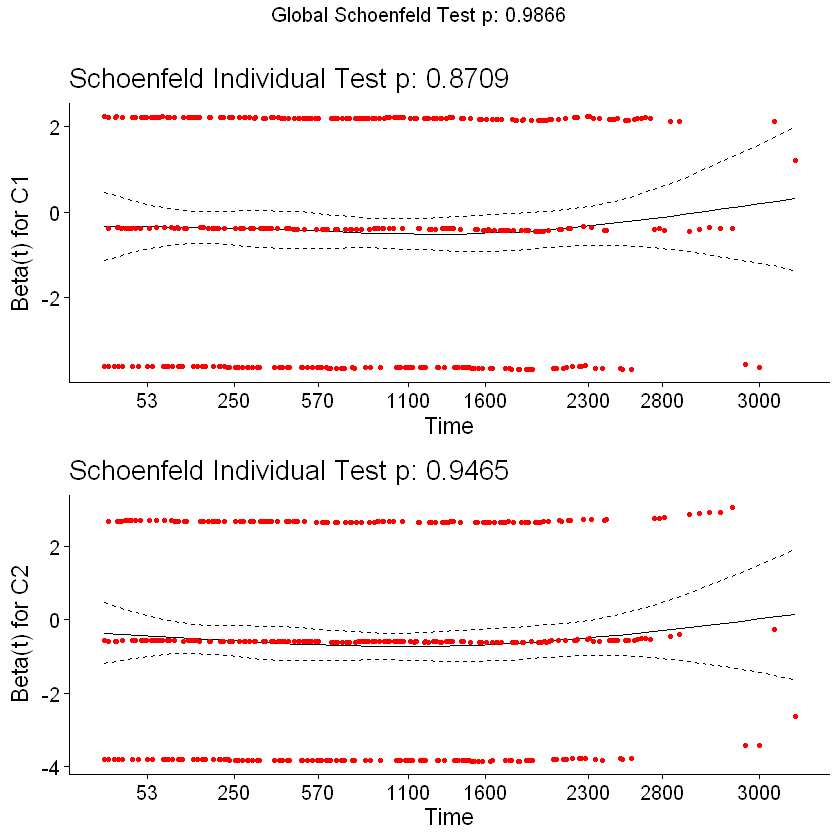

In [30]:
cz <- cox.zph(coxph(Surv(time, MACE) ~ C1 + C2 + C3, data = df))
print(cz)
par(mfrow = c(2, 1), bg = "white")
plot(cz)
ggcoxzph(cz)

In principle, the Schoenfeld residuals are independent of time. A plot that shows a non-random pattern against time is evidence of violation of the PH assumption.

In the figure above, the solid line is a smoothing spline fit to the plot, with the dashed lines representing a ±2σ band around the fit.

- Systematic departures from a horizontal line are indicative of non-proportional hazards, since proportional hazards assumes that estimates $β_i$ do not vary much over time.
- From the graphical inspection, there is no pattern with time.
- *The assumption of proportional hazards appears to be supported for the covariates C1, C2, HI_low, HI_med, age28_60, age60_71*.
- Violations of proportional hazards assumption can be resolved by:
    - Adding *covariate × time* interaction.
    - Stratification (useful for *nuisance* confounders).

           chisq df     p
SE_MS    0.10770  1 0.743
SE_SUP   0.20047  1 0.654
SE_RES   2.92975  1 0.087
SE_STU   4.16938  1 0.041
SE_EX    0.00588  1 0.939
SE_HW    0.77769  1 0.378
SE_PET   0.09725  1 0.755
SE_INT   0.04203  1 0.838
SE_TSI   1.51914  1 0.218
SE_ACTT  0.99319  1 0.319
SE_SH    0.43015  1 0.512
SE_TEH   0.13531  1 0.713
SE_CCH   1.93721  1 0.164
SE_ENH   0.27714  1 0.599
HI_high  0.31858  1 0.572
HI_low   1.87732  1 0.171
GLOBAL  17.47447 16 0.356


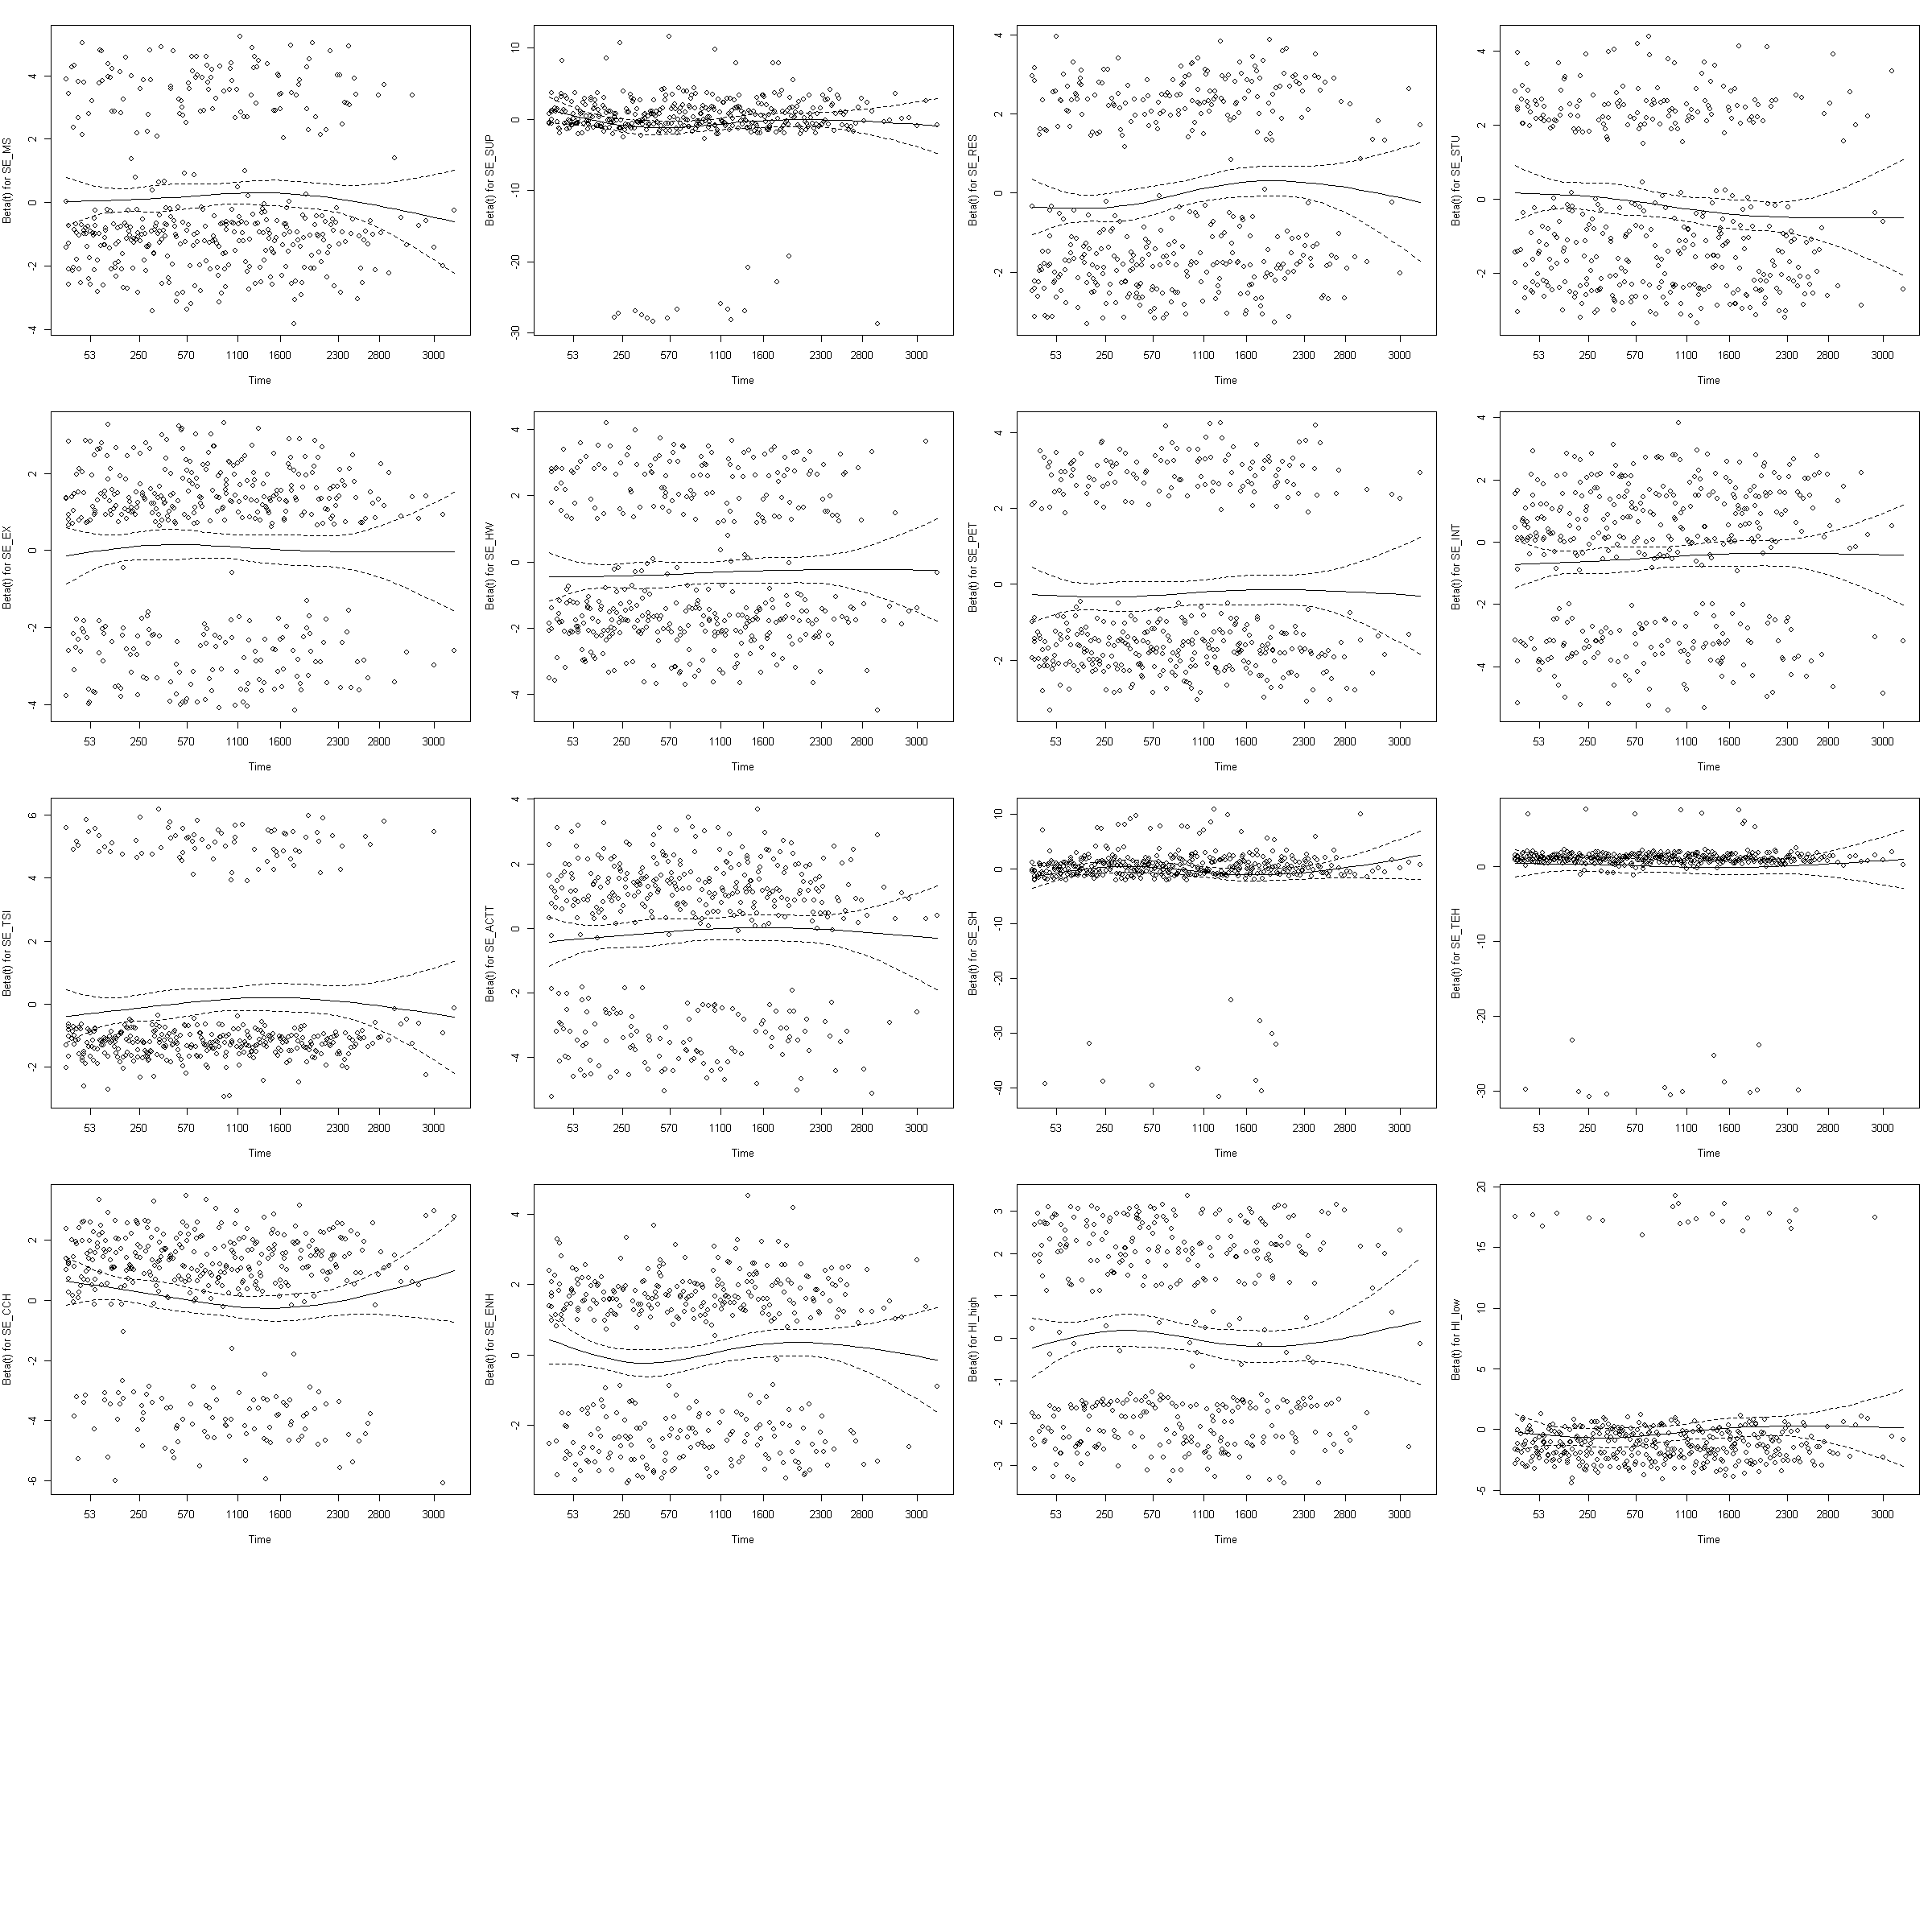

In [31]:
cox_ph <- cox.zph(cox_model)
print(cox_ph)

library(repr)
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfrow = c(5, 4),mar = c(4, 4, 2, 1), bg = "white")
plot(cox_ph)

In [32]:
options(repr.plot.width = NULL, repr.plot.height = NULL)

### Dealing with proportional hazards violations

Stratification provides a general approach to control for the effects of a variable, even if it violates PH.

Drawback: we cannot quantify the effect of the stratification variable on survival (i.e., no coefficient will be estimated).

In the stratified Cox model:

- the Cox model is estimated separately in each stratum
- the baseline hazard function, $h_0(t)$, is allowed to be different across strata  
    - this can accommodate the non-proportional effects of the stratification variable
- the parameter estimates are then averaged across strata to generate one final set of estimates

Put the stratification variable inside `strata()` within the `coxph()` model formula:

In [33]:
cox_model_reduced <- coxph(Surv(time, MACE) ~ SE_MS + SE_SUP + SE_RES + strata(SE_STU) + SE_EX + SE_HW + SE_PET + SE_INT + SE_TSI + SE_ACTT + SE_SH + SE_TEH + SE_CCH + SE_ENH + HI_high + HI_low + HI_med, data = df)
summary(cox_model_reduced)

Call:
coxph(formula = Surv(time, MACE) ~ SE_MS + SE_SUP + SE_RES + 
    strata(SE_STU) + SE_EX + SE_HW + SE_PET + SE_INT + SE_TSI + 
    SE_ACTT + SE_SH + SE_TEH + SE_CCH + SE_ENH + HI_high + HI_low + 
    HI_med, data = df)

  n= 2109, number of events= 405 

            coef exp(coef) se(coef)      z Pr(>|z|)    
SE_MS    0.15340   1.16579  0.11621  1.320  0.18682    
SE_SUP  -0.39657   0.67262  0.27523 -1.441  0.14961    
SE_RES  -0.06628   0.93587  0.10666 -0.621  0.53435    
SE_EX    0.05659   1.05822  0.11059  0.512  0.60885    
SE_HW   -0.35004   0.70466  0.10993 -3.184  0.00145 ** 
SE_PET  -0.25389   0.77577  0.11035 -2.301  0.02140 *  
SE_INT  -0.50458   0.60376  0.11499 -4.388 1.14e-05 ***
SE_TSI   0.00522   1.00523  0.12657  0.041  0.96710    
SE_ACTT -0.12369   0.88365  0.11470 -1.078  0.28085    
SE_SH   -0.37615   0.68650  0.31390 -1.198  0.23079    
SE_TEH   0.16126   1.17499  0.27761  0.581  0.56132    
SE_CCH   0.07476   1.07763  0.12225  0.612  0.54083    
SE_ENH   0.

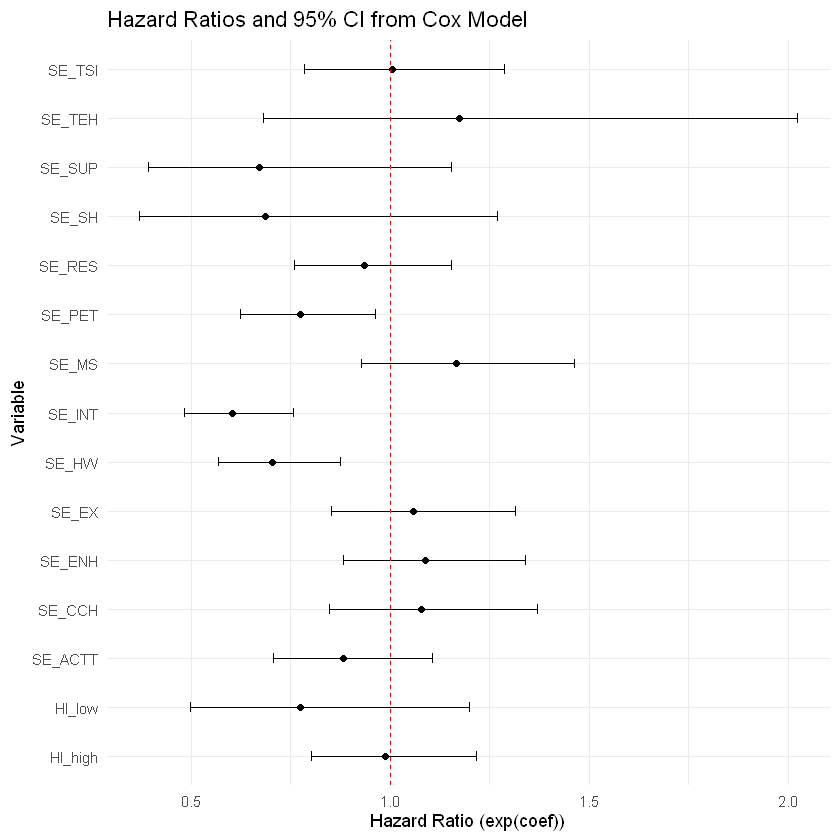

In [34]:
# Extract tidy summary with exponentiated coefficients and confidence intervals
cox_tidy <- tidy(cox_model_reduced, exponentiate = TRUE, conf.int = TRUE) %>% filter(!is.na(estimate))

# Plot hazard ratios with confidence intervals, keeping original variable order
ggplot(cox_tidy, aes(x = term, y = estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
    geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
    coord_flip() +
    labs(
        x = "Variable",
        y = "Hazard Ratio (exp(coef))",
        title = "Hazard Ratios and 95% CI from Cox Model"
    ) +
    theme_minimal()

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message in geom_point(aes(color = estimate > 1), linewidth = 3):
"Ignoring unknown parameters: `linewidth`"


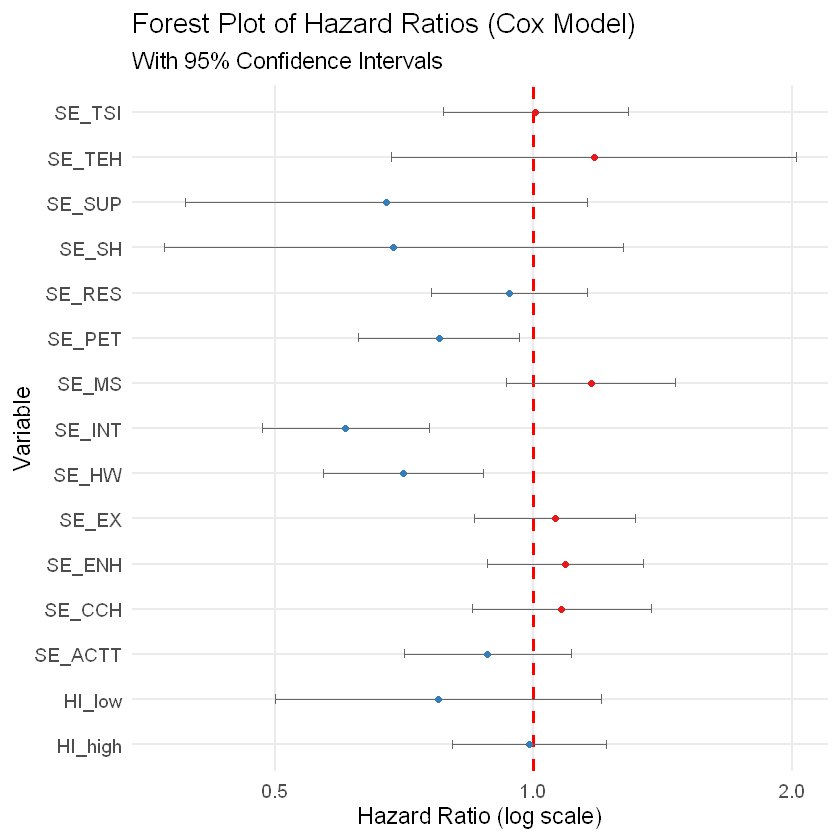

In [35]:
# Enhanced forest plot for hazard ratios with confidence intervals

# Reorder terms by hazard ratio for better visualization
cox_tidy <- tidy(cox_model_reduced, exponentiate = TRUE, conf.int = TRUE) %>% filter(!is.na(estimate))
# cox_tidy <- cox_tidy %>%
#     mutate(term = fct_reorder(term, estimate))

ggplot(cox_tidy, aes(x = estimate, y = term)) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "red", size = 1) +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2, color = "grey40") +
    geom_point(aes(color = estimate > 1), linewidth = 3) +
    scale_color_manual(values = c("TRUE" = "#E41A1C", "FALSE" = "#377EB8"), guide = "none") +
    scale_x_log10() +
    labs(
        x = "Hazard Ratio (log scale)",
        y = "Variable",
        title = "Forest Plot of Hazard Ratios (Cox Model)",
        subtitle = "With 95% Confidence Intervals"
    ) +
    theme_minimal(base_size = 14) +
    theme(panel.grid.minor.x = element_blank())

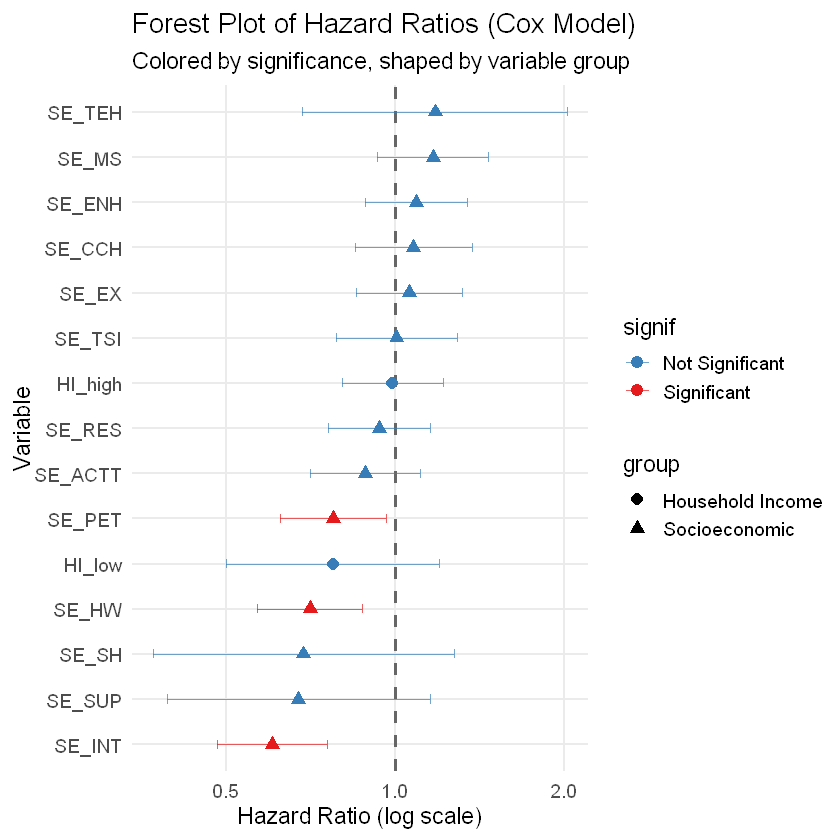

In [36]:
# Fancy forest plot with variable grouping and significance highlighting
cox_tidy <- tidy(cox_model_reduced, exponentiate = TRUE, conf.int = TRUE) %>% filter(!is.na(estimate))

# Add significance column
cox_tidy <- cox_tidy %>%
    mutate(signif = ifelse(p.value < 0.05, "Significant", "Not Significant"))

# Example: group variables by prefix (e.g., MH_, SE_, age, HI_, C)
cox_tidy$group <- case_when(
    grepl("^MH_", cox_tidy$term) ~ "Medical History",
    grepl("^SE_", cox_tidy$term) ~ "Socioeconomic",
    grepl("^age", cox_tidy$term) ~ "Age",
    grepl("^HI_", cox_tidy$term) ~ "Household Income",
    grepl("^C[123]$", cox_tidy$term) ~ "Cluster",
    TRUE ~ "Other"
)

ggplot(cox_tidy, aes(x = estimate, y = fct_reorder(term, estimate), color = signif, shape = group)) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "grey40", size = 1) +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2, alpha = 0.7) +
    geom_point(size = 3) +
    scale_color_manual(values = c("Significant" = "#E41A1C", "Not Significant" = "#377EB8")) +
    scale_x_log10() +
    labs(
        x = "Hazard Ratio (log scale)",
        y = "Variable",
        title = "Forest Plot of Hazard Ratios (Cox Model)",
        subtitle = "Colored by significance, shaped by variable group"
    ) +
    theme_minimal(base_size = 14) +
    theme(panel.grid.minor.x = element_blank())

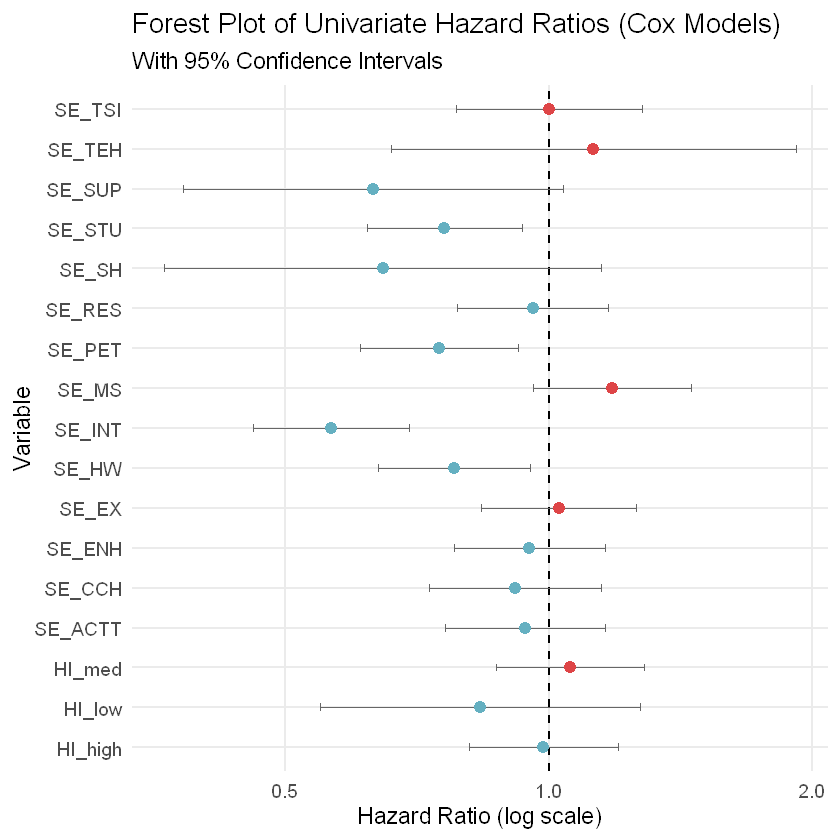

In [37]:
# PLOT FOR THE MEMORY

# List of variables to analyze separately (from cox_model_reduced, excluding strata)
vars <- c("SE_MS", "SE_SUP", "SE_RES", "SE_STU", "SE_EX", "SE_HW", "SE_PET", "SE_INT", "SE_TSI", "SE_ACTT", "SE_SH", "SE_TEH", "SE_CCH", "SE_ENH", "HI_high", "HI_low", "HI_med")

# Fit univariate Cox models and collect tidy results
cox_uni_list <- lapply(vars, function(v) {
    f <- as.formula(paste0("Surv(time, MACE) ~ ", v))
    mod <- coxph(f, data = df)
    tidy(mod, exponentiate = TRUE, conf.int = TRUE) %>%
        filter(!is.na(estimate))
})
cox_uni_tidy <- bind_rows(cox_uni_list)

ggplot(cox_uni_tidy, aes(x = estimate, y = term)) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "black", size = 0.8) +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2, color = "grey40") +
    geom_point(aes(color = estimate > 1), size = 3) +
    scale_color_manual(values = c("TRUE" = "#de4547", "FALSE" = "#65b0c1"), guide = "none") +
    scale_x_log10() +
    labs(
        x = "Hazard Ratio (log scale)",
        y = "Variable",
        title = "Forest Plot of Univariate Hazard Ratios (Cox Models)",
        subtitle = "With 95% Confidence Intervals"
    ) +
    theme_minimal(base_size = 14) +
    theme(panel.grid.minor.x = element_blank())

In [38]:
summary(coxph(Surv(time, MACE) ~ SE_HW, data = df))

Call:
coxph(formula = Surv(time, MACE) ~ SE_HW, data = df)

  n= 2109, number of events= 405 

         coef exp(coef) se(coef)      z Pr(>|z|)  
SE_HW -0.2477    0.7806   0.1020 -2.429   0.0151 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

      exp(coef) exp(-coef) lower .95 upper .95
SE_HW    0.7806      1.281    0.6392    0.9533

Concordance= 0.532  (se = 0.013 )
Likelihood ratio test= 5.99  on 1 df,   p=0.01
Wald test            = 5.9  on 1 df,   p=0.02
Score (logrank) test = 5.93  on 1 df,   p=0.01
